**Light GBM**

Reference: https://medium.com/@am.sharma/lgbm-on-colab-with-gpu-c1c09e83f2af

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import scipy.stats as ss
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import plotly.graph_objs as go
import plotly.offline as py

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
%matplotlib inline

Load Titanic set

In [2]:
train_df  = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
test_df  = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   survived            627 non-null    int64  
 1   sex                 627 non-null    object 
 2   age                 627 non-null    float64
 3   n_siblings_spouses  627 non-null    int64  
 4   parch               627 non-null    int64  
 5   fare                627 non-null    float64
 6   class               627 non-null    object 
 7   deck                627 non-null    object 
 8   embark_town         627 non-null    object 
 9   alone               627 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 49.1+ KB


In [3]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


Preprocess

In [4]:
#embarked_encoder = LabelEncoder()
#embarked_encoder.fit(train_df['embark_town'].fillna('Null'))

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [6]:
# Dataframes to work on
df_list = [train_df, test_df]

for df in df_list:    
    
    # Record anyone travelling alone
    df['alone'] = (df['n_siblings_spouses'] == 0) & (df['parch'] == 0)
    
    # Transform 'Embarked'
    df['embark_town'].fillna('Null', inplace=True)
    #df['alone'] = embarked_encoder.transform(df['alone'])
    
    # Transform 'Sex'
    df.loc[df['sex'] == 'female','sex'] = 0#
    df.loc[df['sex'] == 'male','sex'] = 1
    df['sex'] = df['sex'].astype('int8') 

    num_of_columns = df.shape[1]
 
    for i in range(0, num_of_columns):
      column_name = df.columns[i]
      column_type = df[column_name].dtypes
            
      if column_type == 'object':
        le.fit(df[column_name])
        feature_classes = list(le.classes_)
        encoded_feature = le.transform(df[column_name])
        df[column_name] = pd.DataFrame(encoded_feature)
 

In [7]:
train_df.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,1,22.0,1,0,7.2500,2,7,2,False
1,1,0,38.0,1,0,71.2833,0,2,0,False
2,1,0,26.0,0,0,7.9250,2,7,2,True
3,1,0,35.0,1,0,53.1000,0,2,2,False
4,0,1,28.0,0,0,8.4583,2,7,1,True


In [8]:
y = train_df.pop('survived')

# Create a hold out randomly
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)

# Create an LGBM dataset for training
categorical_features = ['alone', 'sex', 'class', 'embark_town', 'deck']
train_data = lgbm.Dataset(data=X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)

# Create an LGBM dataset from the test
test_data = lgbm.Dataset(data=X_test, label=y_test, categorical_feature=categorical_features, free_raw_data=False)

# Create a dataset for the FULL training 
final_train_set = lgbm.Dataset(data=train_df, label=y, 
                               categorical_feature=categorical_features, free_raw_data=False)


Hyperparameters for LGBM

In [9]:
fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X_train,y_train)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 500 

Cross validation Training 5 folds

In [10]:
#intializing lgbm and lunching the search
random_state=42
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X_train, y_train, **fit_params)
print('Best score reached: {} with params: {} '.format(grid_search.best_score_, grid_search.best_params_))

opt_parameters =  grid_search.best_params_

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best score reached: 0.8124158415841585 with params: {'colsample_bytree': 0.5536409936567944, 'learning_rate': 0.3, 'max_depth': 6, 'min_child_samples': 114, 'min_child_weight': 0.01, 'n_estimators': 800, 'num_leaves': 37, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.31146516352470055} 


[Parallel(n_jobs=1)]: Done 2500 out of 2500 | elapsed:   42.7s finished


Show results for Cross validation 5 folds

In [11]:
scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
res = []
for sc in scores:
    scores = cross_val_score(lgbm_clf, X_train, y_train, cv = 5, scoring = sc)
    #print(sc, scores)
    res.append(scores)
df = pd.DataFrame(res).T
df.loc['mean'] = df.mean()
df.loc['std'] = df.std()
df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

trace = go.Table(
    header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                line = dict(color='#7D7F80'),
                fill = dict(color='#a1c3d1'),
                align = ['center'],
                font = dict(size = 15)),
    cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                       np.round(df['accuracy'],4),
                       np.round(df['precision'],4),
                       np.round(df['recall'],4),
                       np.round(df['f1'],4),
                       np.round(df['roc_auc'],4)],
               line = dict(color='#7D7F80'),
               fill = dict(color='#EDFAFF'),
               align = ['center'], font = dict(size = 15)))

layout = dict(width=800, height=400, title = '<b>Cross validation - 5 folds', font = dict(size = 15))
fig = dict(data=[trace], layout=layout)
py.iplot(fig, filename = 'styled_table')

Important features

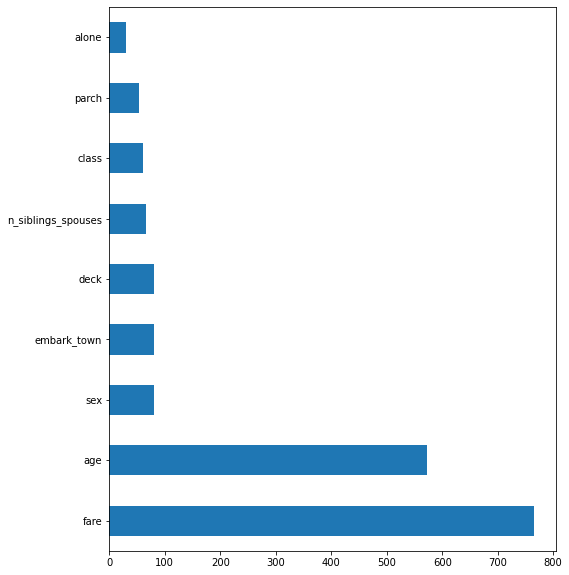

In [12]:
lgbm_clf = lgbm.LGBMClassifier(silent=True, metric='None', n_jobs=4)
lgbm_clf.fit(X_train, y_train)
feat_imp = pd.Series(lgbm_clf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))